In [1]:
# modules for structure decoration
import os
import itertools
from tqdm.notebook import tqdm
import glob
from glob import iglob
from copy import deepcopy
from collections import defaultdict
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks',
        color_codes=True, rc={'legend.frameon': False})
print(f"pandas version: {pd.__version__}")
print(f"numpy version: {np.__version__}")
print(f"matplotlib version: {matplotlib.__version__}")
print(f"seaborn version: {sns.__version__}")

from pymatgen.core import Composition, Structure
from pymatgen.analysis import local_env

pandas version: 1.1.4
numpy version: 1.21.0
matplotlib version: 3.4.2
seaborn version: 0.11.1


In [2]:
os.chdir('../../')
print(os.getcwd())
from src import utils
import preprocess_crystals as preprocess

/lustre/eaglefs/projects/rlmolecule/jlaw/crystal-gnn-fork


RDKit WARNING: [12:17:37] Enabling RDKit 2019.09.3 jupyter extensions


## Prediction error by element
Since we're performing ionic substitution, there may be a correlation of a given ICSD element being replaced with a specific battery element and the prediction error.

Here I'm going to build a heatmap of the prediction error and the element replacement.

In [ ]:
# First we need to figure out which battery elements replaced which ICSD elements


In [3]:
icsd_prototypes_file = "/home/jlaw/projects/arpa-e/crystals/rlmolecule/rlmolecule/crystal/inputs/icsd_prototypes.json.gz"
icsd_proto_strcs = utils.load_structures_from_json(icsd_prototypes_file)

Loading /home/jlaw/projects/arpa-e/crystals/rlmolecule/rlmolecule/crystal/inputs/icsd_prototypes.json.gz
	4170 loaded


In [4]:
# icsd_strc_file = "inputs/structures/icsd_structures.json.gz"
# icsd_strcs = utils.load_structures_from_json(icsd_strc_file)
unrel_battery_strc_file = "inputs/structures/battery_unrelaxed_structures.json.gz"
unrel_strcs = utils.load_structures_from_json(unrel_battery_strc_file)


Loading inputs/structures/battery_unrelaxed_structures.json.gz
	67840 loaded


In [5]:
print(list(unrel_strcs.keys())[:3])

['Mg1Ti1Cd1Cl5N1_sg129_icsd_420040_4', 'Mg1Sc1F1Br4_sg15_icsd_183878_4', 'K3F1O1_sg2_icsd_069655_2']


In [6]:
print(list(icsd_proto_strcs.keys())[:3])

['_1_1_1_2_3|orthorhombic|POSCAR_sg62_icsd_174512', '_1_1_1_2_3|orthorhombic|POSCAR_sg70_icsd_079945', '_1_1_1_2_3|monoclinic|POSCAR_sg15_icsd_109946']


In [34]:
# map the prototype structure IDs to the ICSD ID
icsd_strc_ids_dict = {'_'.join(k.split('_')[-2:]): k for k in icsd_proto_strcs.keys()}
# also map the unrelaxed IDs to the prototype string
unrel_to_proto = {}
for unrel_strc_id in unrel_strcs:
    icsd_id = '_'.join(unrel_strc_id.split('_')[2:4])
    icsd_id_str = icsd_strc_ids_dict[icsd_id]
    unrel_to_proto[unrel_strc_id] = icsd_id_str

In [8]:
# try these:
strc_id = "Li1B1O2_sg7_icsd_248117_1"
icsd_id = '_'.join(strc_id.split('_')[2:4])
icsd_id_str = icsd_strc_ids_dict[icsd_id]
icsd_id_str

'_1_1_2|monoclinic|POSCAR_sg7_icsd_248117'

In [9]:
icsd_proto_strcs[icsd_id_str].composition

Comp: Na8 As8 Se16

In [32]:
# many of the prototype ICSD structures were since pruned from the training dataset
not_found = set()
num_battery = 0
for strc_id in unrel_strcs:
    icsd_id = '_'.join(strc_id.split('_')[2:4])
    if icsd_id not in icsd_strcs:
        not_found.add(icsd_id)
        num_battery += 1
print(len(not_found))
print(num_battery)

1601
44021


In [34]:
with open('icsd_prototype_ids_pruned.txt', 'w') as out:
    out.write('\n'.join(not_found) + '\n')

In [56]:
def match_replacement_eles(strc1, strc2):
    """ Find which elements were replaced by what.
    Since we used ionic substitution to build the unrelaxed battery dataset, 
    the coordinates should match exactly
    """
    ele_map = defaultdict(set)
    for i, site1 in enumerate(strc1.sites):
        site2 = strc2.sites[i]
        for x1, x2 in zip(site1.coords, site2.coords):
            x1 = np.floor(abs(x1))
            x2 = np.floor(abs(x2))
            if x1 != x2:
                print(f"WARNING: coordinates don't match: {x1}, {x2} for {strc1.composition} and {strc2.composition}")
        ele1 = site1.species_string
        ele2 = site2.species_string
        ele_map[ele1].add(ele2)
    # now make sure there is only a 1:1 mapping

    real_ele_map = {}
    for e1, e2_set in ele_map.items():
        assert len(e2_set) == 1, f"ERROR: multiple matching sites for {strc1.composition} and {strc2.composition}"
        real_ele_map[e1] = list(e2_set)[0]
            
    assert len(set(real_ele_map.keys())) == len(set(real_ele_map.values()))
    
    return real_ele_map

match_replacement_eles(strc1, strc2)

{'Na': 'Li', 'As': 'B', 'Se': 'O'}

In [58]:
print(ele_replacement_maps['Li1B1O2_sg7_icsd_248117_1'])
print(ele_replacement_maps['Li1B1O2_sg7_icsd_248117_2'])

{'Na': 'Li', 'As': 'B', 'Se': 'O'}
{'Na': 'B', 'As': 'Li', 'Se': 'O'}


In [57]:
ele_replacement_maps = {}
for unrel_strc_id, unrel_strc in unrel_strcs.items():
    icsd_id_str = unrel_to_proto[unrel_strc_id]
    icsd_strc = icsd_proto_strcs[icsd_id_str]
    
#     print(icsd_id_str, unrel_strc_id)
    ele_map = match_replacement_eles(icsd_strc, unrel_strc)
    ele_replacement_maps[unrel_strc_id] = ele_map

In [128]:
# now get the err for each unrel battery strc
exp_dir = "outputs/icsd_battery_unrelaxed/hypo_loc_icsd_randsub0_05_seed1"
pred_energy_file = exp_dir + '/predicted_test.csv'
pred_df = pd.read_csv(pred_energy_file)
pred_df['pred_err'] = abs(pred_df['predicted_energyperatom'] - pred_df['energyperatom'])
pred_err = dict(zip(pred_df['id'], pred_df['pred_err']))
print(len(pred_err))

6576


In [129]:
# now get the err for each unrel battery strc
exp_dir = "outputs/icsd_battery_unrelaxed/hypo_loc_icsd_randsub0_05_seed2"
pred_energy_file = exp_dir + '/predicted_test.csv'
pred_df = pd.read_csv(pred_energy_file)
pred_df['pred_err'] = abs(pred_df['predicted_energyperatom'] - pred_df['energyperatom'])
pred_err.update(dict(zip(pred_df['id'], pred_df['pred_err'])))
print(len(pred_err))

12545


In [130]:
# now get the err for each unrel battery strc
exp_dir = "outputs/icsd_battery_unrelaxed/hypo_loc_icsd_randsub0_05_seed3"
pred_energy_file = exp_dir + '/predicted_test.csv'
pred_df = pd.read_csv(pred_energy_file)
pred_df['pred_err'] = abs(pred_df['predicted_energyperatom'] - pred_df['energyperatom'])
pred_err.update(dict(zip(pred_df['id'], pred_df['pred_err'])))
print(len(pred_err))

17781


In [131]:
pred_df.tail()

,comp_type,composition,id,energyperatom,predicted_energyperatom,pred_err
6562,11123.0,Mg1La1B1Br2S3,Mg1La1B1Br2S3_sg176_icsd_095740_5,-4.332167,-4.590249,0.258081
6563,11123.0,Mg1La1B1Br2S3,Mg1La1B1Br2S3_sg4_icsd_152108_3,-4.381653,-4.691982,0.310330
6564,11123.0,Mg1La1B1Br2S3,Mg1La1B1Br2S3_sg14_icsd_180844_2,-4.596006,-4.663151,0.067145
6565,11123.0,Mg1La1B1Br2S3,Mg1La1B1Br2S3_sg190_icsd_421141_5,-4.476938,-4.564667,0.087728
6566,11123.0,Mg1La1B1Br2S3,Mg1La1B1Br2S3_sg190_icsd_421141_4,-4.811610,-4.612307,0.199303


In [132]:
skipped = []
ele_repl_err = defaultdict(dict)
for unrel_strc_id, ele_map in ele_replacement_maps.items():
    if unrel_strc_id not in pred_err:
        skipped.append(unrel_strc_id)
        continue
    repl_err = pred_err[unrel_strc_id]
    for e1, e2 in ele_map.items():
        if e2 not in ele_repl_err[e1]:
                ele_repl_err[e1][e2] = []
        ele_repl_err[e1][e2].append(repl_err)
       
print(f"skipped {len(skipped)}")
# now get the avg err per element replacement
avg_ele_replacement_err = []
for e1 in ele_repl_err:
    for e2, errs in ele_repl_err[e1].items():
        avg_err = sum(errs) / float(len(errs))
        avg_ele_replacement_err.append((e1, e2, avg_err))
    
print(avg_ele_replacement_err[:5])
# print(list(ele_repl_err.items())[:2])

skipped 52421
[('Na', 'Cd', 0.19613251834992948), ('Na', 'Hf', 0.23041532923532493), ('Na', 'O', 0.17011838696034146), ('Na', 'Ti', 0.23679153247776308), ('Na', 'N', 0.1837713977350571)]


In [142]:
err_count = []
for e1 in ele_repl_err:
    for e2, errs in ele_repl_err[e1].items():
        count = len(errs)
        err_count.append((e1, e2, count))

In [133]:
df = pd.DataFrame(avg_ele_replacement_err, columns=['icsd_ele', 'batt_ele', 'avg_err'])
df.head()

,icsd_ele,batt_ele,avg_err
0,Na,Cd,0.196133
1,Na,Hf,0.230415
2,Na,O,0.170118
3,Na,Ti,0.236792
4,Na,N,0.183771


In [134]:
df['icsd_ele'].value_counts()

Bi     28
Co     28
Cs     28
Cd     28
Mn     28
       ..
D0+     5
Np      4
Cm      4
Po      3
Am      2
Name: icsd_ele, Length: 87, dtype: int64

In [135]:
df['batt_ele'].value_counts()

Zn    85
Mg    84
Li    82
Hg    81
O     81
K     81
P     80
N     80
I     78
Cd    78
Na    77
Ti    77
S     77
Br    76
Sb    76
F     74
Hf    73
B     73
Sc    73
W     73
Ge    72
Al    67
Sn    66
Y     64
Cl    63
Zr    61
La    61
Si    60
Name: batt_ele, dtype: int64

In [136]:
df = df.pivot('icsd_ele', 'batt_ele', 'avg_err')
df

batt_ele,Al,B,Br,Cd,Cl,F,Ge,Hf,Hg,I,K,La,Li,Mg,N,Na,O,P,S,Sb,Sc,Si,Sn,Ti,W,Y,Zn,Zr
icsd_ele,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ag,0.073876,0.108053,0.122431,0.122536,0.169894,0.099222,NaN,0.099089,0.112316,0.099627,0.140669,0.162522,0.119302,0.124406,0.143290,0.096443,0.136153,0.159620,0.104264,0.145681,0.069316,0.172408,0.143536,0.092119,0.161016,0.316719,0.089472,0.158655
Al,0.231616,0.164922,0.153976,0.147743,0.116226,0.125173,0.201107,0.218690,0.278155,0.138645,0.237582,0.118822,0.178113,0.171301,0.186995,0.148051,0.117441,0.207239,0.171473,0.289444,0.118245,0.135033,0.092317,0.120948,0.081476,0.093502,0.131215,0.133221
Am,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.078478,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.005633,NaN
As,0.214092,0.226773,0.091585,0.194684,0.238130,0.458123,0.186690,0.117870,0.136295,0.322839,0.098105,0.081974,0.127923,0.193746,0.175255,0.140757,0.166048,0.203814,0.329461,0.088773,0.075105,0.097247,0.092870,0.175731,0.116561,0.111193,0.164395,0.093818
Au,0.333295,0.418183,0.146099,0.109152,0.180707,0.171837,0.157762,0.168480,0.139750,0.279274,0.275963,0.073320,0.163252,0.250001,0.293481,0.161851,0.097990,0.153768,0.162201,0.138665,0.051502,NaN,0.070234,0.140543,0.138943,0.133336,0.127449,0.163180
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Xe,NaN,0.102390,0.026926,0.132625,NaN,NaN,0.086963,0.401572,NaN,NaN,0.137823,0.272326,0.140514,0.171533,NaN,NaN,NaN,0.082914,NaN,NaN,NaN,NaN,0.046976,NaN,0.040348,NaN,0.022761,NaN
Y,0.200061,0.424999,0.071138,0.203902,0.161327,0.175409,0.339020,0.190964,0.067039,0.084106,0.131135,0.164506,0.162216,0.201215,0.257978,0.180546,0.129819,0.120102,0.221803,0.225327,0.175054,0.399158,0.396339,0.308265,0.227484,0.175186,0.210303,0.303223
Yb,0.087550,1.833912,0.067499,0.071268,0.015541,0.120953,0.475464,0.125422,0.107619,0.142898,0.116633,NaN,0.308489,0.171699,0.226508,0.029899,0.127512,0.075592,0.289458,0.216081,0.392979,NaN,NaN,0.088860,0.602353,0.253650,0.232807,NaN


In [137]:
s = df.mean().sort_values(ascending=False)
df = df[s.index]

In [138]:
df2 = df.T
s = df2.mean().sort_values(ascending=False)
df = df2[s.index].T

In [165]:
df2 = pd.DataFrame(err_count, columns=['icsd_ele', 'batt_ele', 'count'])
df2['count'] = df2['count']
df2 = df2.pivot('icsd_ele', 'batt_ele', 'count')
df2 = df2[df.columns]
df2 = df2.T[df.T.columns].T
df_counts = df2
df_counts.head()

batt_ele,Hf,F,B,Si,N,Sc,I,Mg,Ge,O,Cl,Li,W,Cd,Sb,Zn,Na,Hg,K,S,Ti,Sn,Zr,Al,La,Y,P,Br
icsd_ele,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Ge,24.0,11.0,10.0,5.0,31.0,4.0,12.0,47.0,23.0,18.0,7.0,61.0,15.0,28.0,15.0,49.0,20.0,32.0,31.0,20.0,22.0,8.0,1.0,9.0,2.0,2.0,26.0,27.0
Ho,NaN,1.0,2.0,NaN,6.0,NaN,3.0,2.0,1.0,1.0,NaN,2.0,NaN,1.0,2.0,4.0,NaN,3.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,2.0,NaN
Po,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pr,NaN,NaN,3.0,NaN,4.0,1.0,2.0,9.0,1.0,6.0,NaN,5.0,2.0,3.0,NaN,4.0,5.0,2.0,5.0,1.0,3.0,2.0,1.0,1.0,NaN,2.0,4.0,2.0
B,15.0,19.0,48.0,6.0,76.0,27.0,25.0,62.0,19.0,42.0,14.0,98.0,34.0,31.0,20.0,32.0,44.0,37.0,43.0,47.0,27.0,14.0,11.0,4.0,9.0,19.0,28.0,32.0


In [160]:
# a lot of ICSD elements are only present a handful of times
icsd_counts = df_counts.T.sum()
icsd_counts[icsd_counts < 50]

icsd_ele
Ho     32.0
Po      3.0
D0+    18.0
Tm     37.0
Pa      5.0
Xe     23.0
Pu     16.0
Tc     23.0
Cm      5.0
Np      7.0
Am      2.0
dtype: float64

outputs/viz/err_by_element/battery_unrelaxed_seeds1_2_3-ann.svg


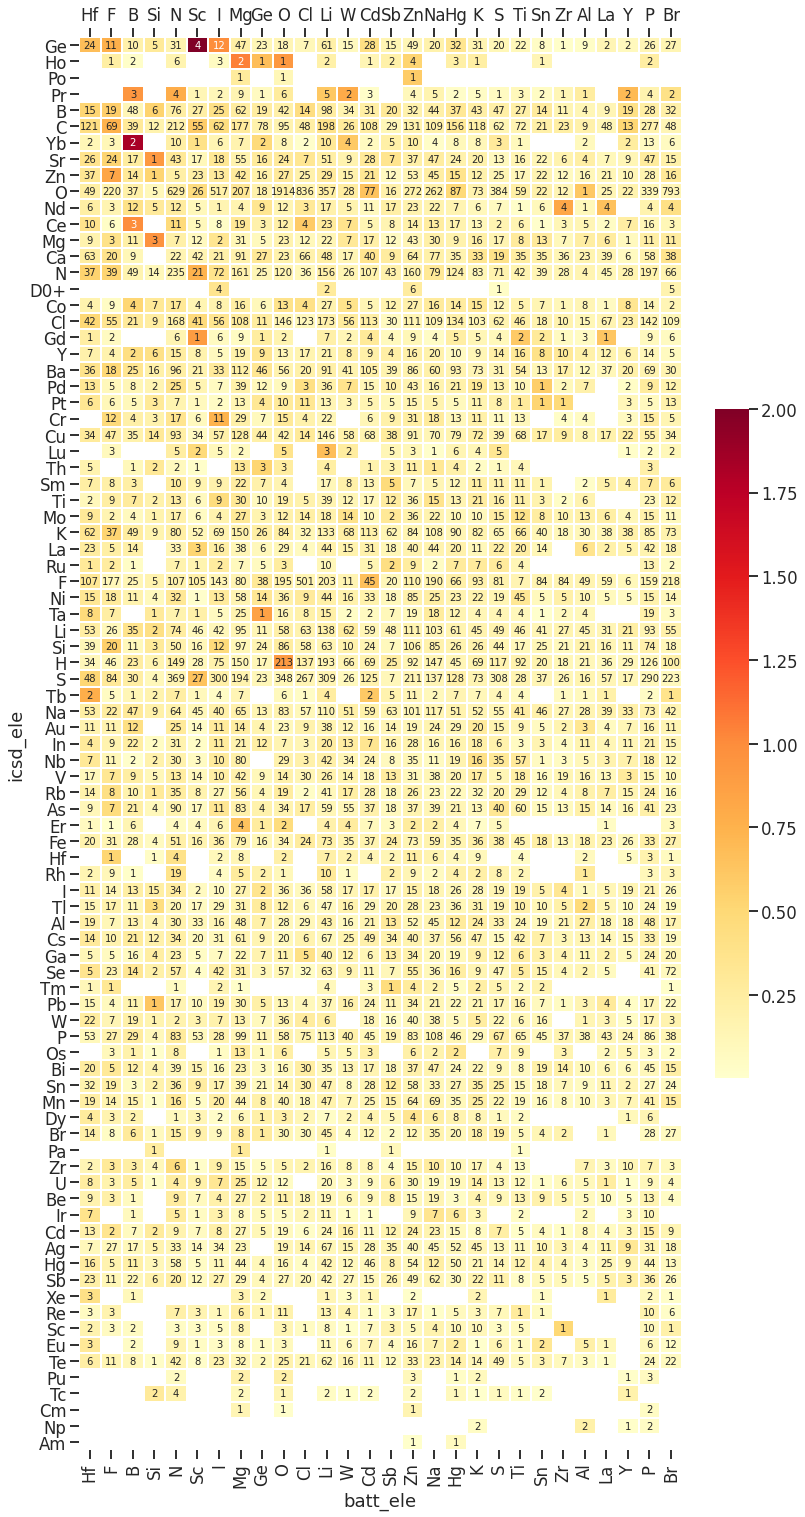

In [170]:
f, ax = plt.subplots(figsize=(12,26))
ax = sns.heatmap(df, 
            xticklabels=True, yticklabels=True,
            cmap='YlOrRd', linewidths=.1,
            cbar_kws={'fraction': .05},
            vmax=2.0,
            annot=df_counts, fmt='.0f', annot_kws={'fontsize': 10}
           )
ax.tick_params(top=True, labeltop=True)

out_file = "outputs/viz/err_by_element/battery_unrelaxed_seeds1_2_3-ann.svg"
os.makedirs(os.path.dirname(out_file), exist_ok=True)
print(out_file)
plt.savefig(out_file, bbox_inches='tight')
plt.savefig(out_file.replace('.svg','.png'), bbox_inches='tight')
plt.savefig(out_file.replace('.svg','.pdf'), bbox_inches='tight')

outputs/viz/err_by_element/battery_unrelaxed_seeds1_2_3.svg


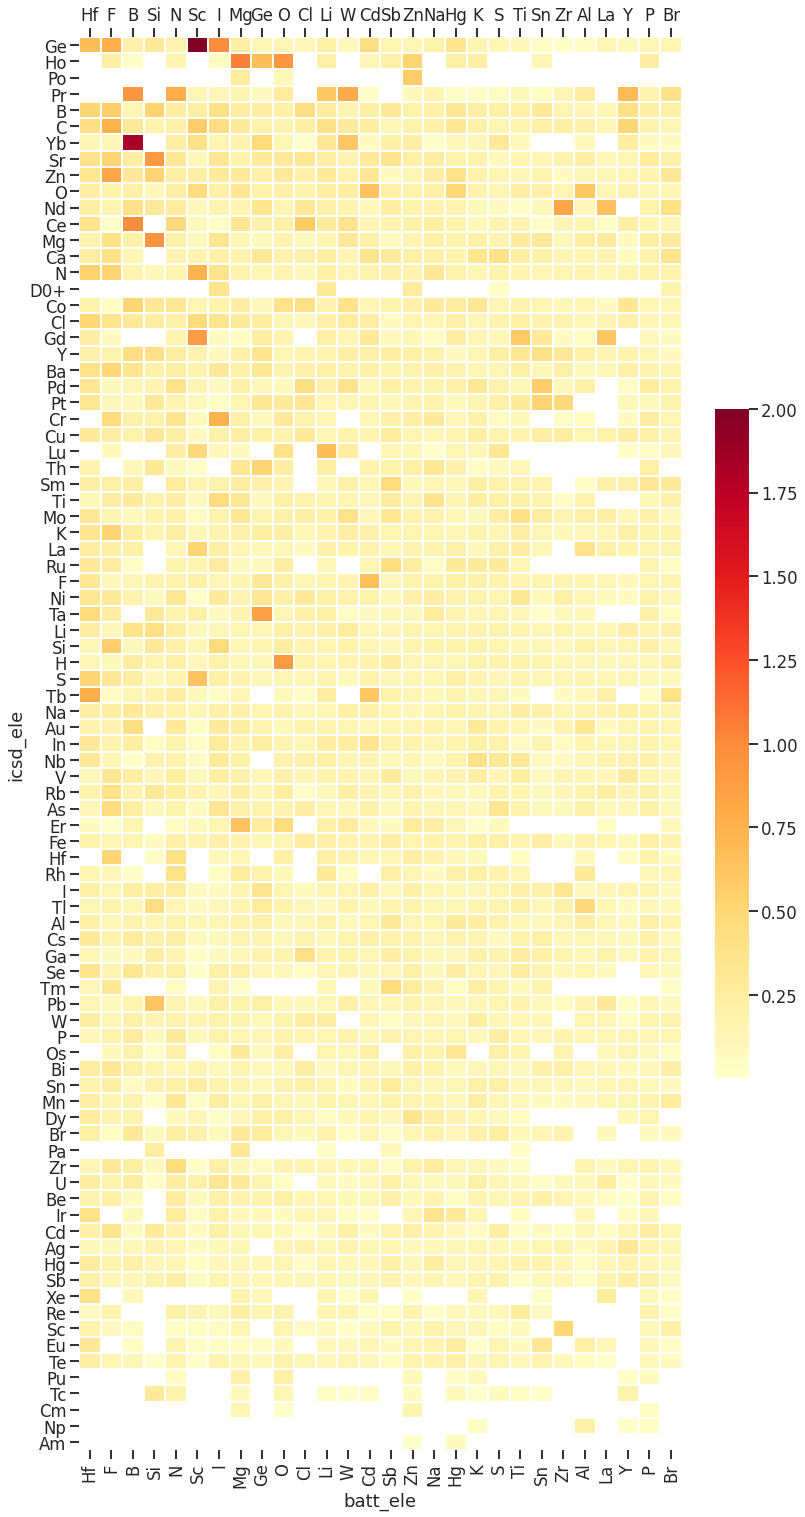

In [141]:
f, ax = plt.subplots(figsize=(12,26))
ax = sns.heatmap(df, 
            xticklabels=True, yticklabels=True,
            cmap='YlOrRd', linewidths=.1,
            cbar_kws={'fraction': .05},
            vmax=2.0,
           )
ax.tick_params(top=True, labeltop=True)

out_file = "outputs/viz/err_by_element/battery_unrelaxed_seeds1_2_3.svg"
os.makedirs(os.path.dirname(out_file), exist_ok=True)
print(out_file)
plt.savefig(out_file, bbox_inches='tight')
plt.savefig(out_file.replace('.svg','.png'), bbox_inches='tight')
plt.savefig(out_file.replace('.svg','.pdf'), bbox_inches='tight')

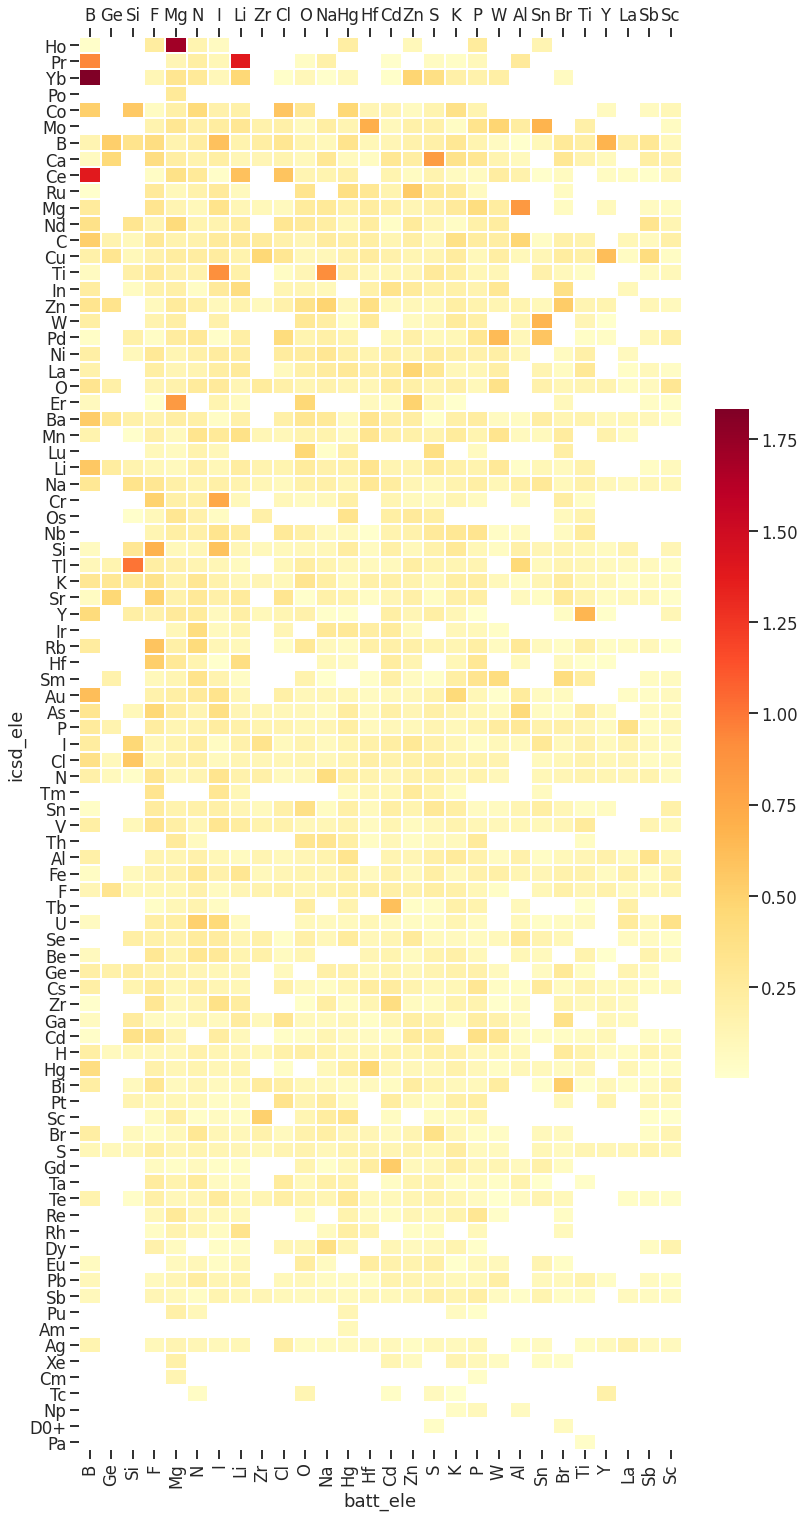

In [127]:
f, ax = plt.subplots(figsize=(12,26))
ax = sns.heatmap(df, 
            xticklabels=True, yticklabels=True,
            cmap='YlOrRd', linewidths=.1,
            cbar_kws={'fraction': .05},
           )
ax.tick_params(top=True, labeltop=True)

ValueError: The condensed distance matrix must contain only finite values.

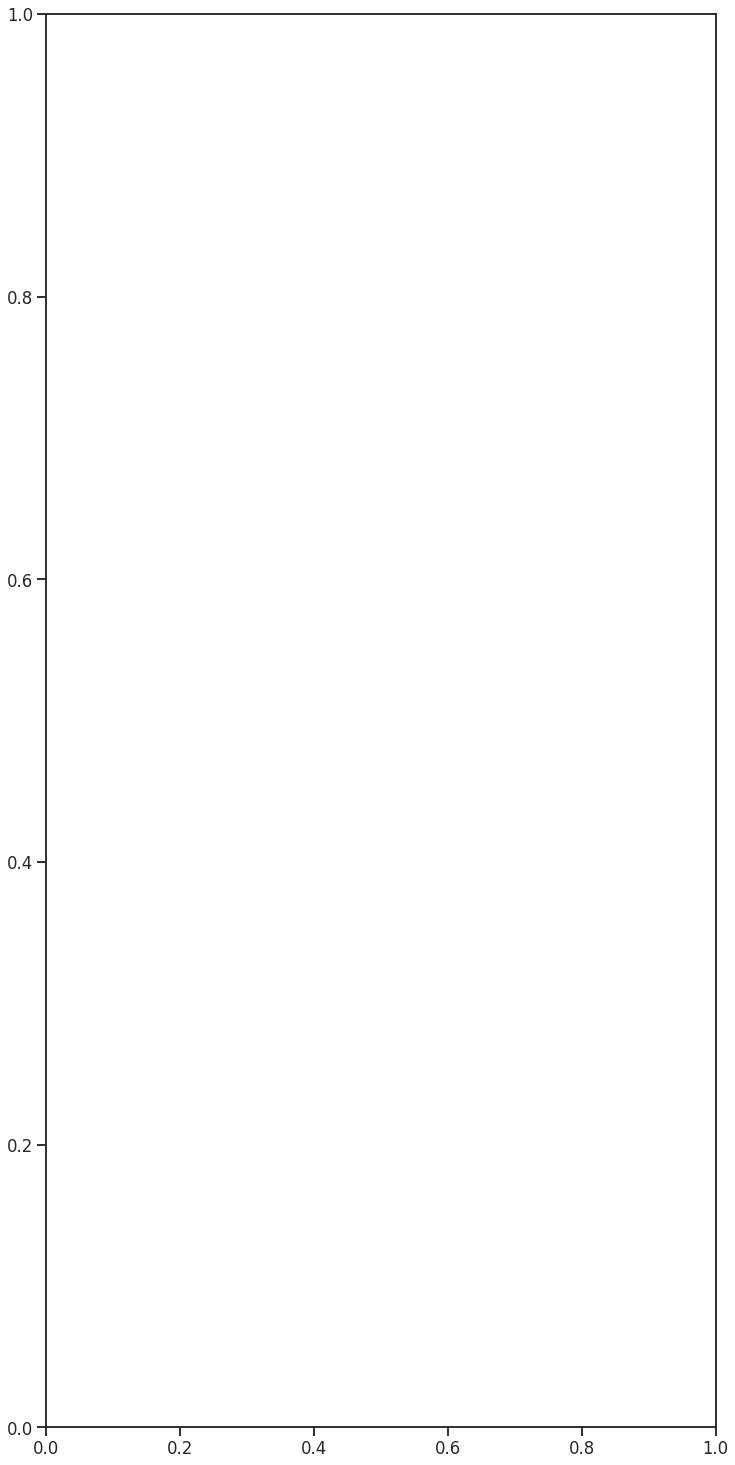

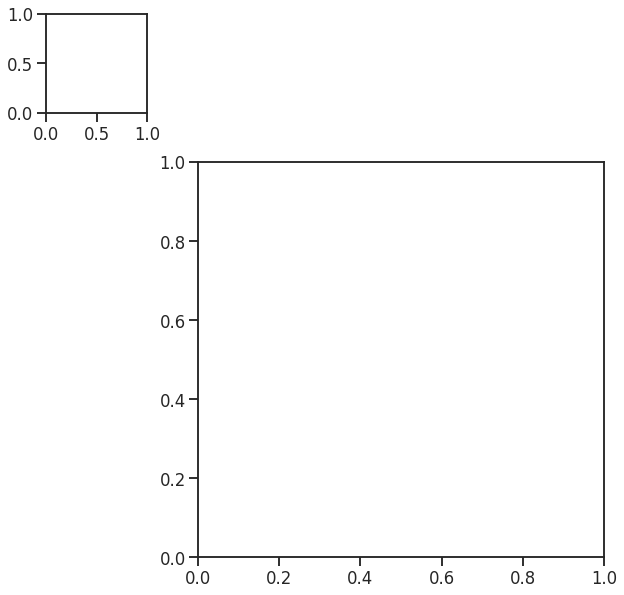

In [97]:
f, ax = plt.subplots(figsize=(12,26))
sns.clustermap(df, 
            xticklabels=True, yticklabels=True,
            cmap='YlOrRd',
           )

In [45]:
strc = unrel_strcs[strc_id]
strc[0]

PeriodicSite: Li (11.4508, 3.1004, 3.1342) [0.9823, 0.5253, 0.2651]

In [47]:
strc = unrel_strcs[strc_id]
strc[0].c

0.2651

In [19]:
unrel_strcs[strc_id].composition

Comp: Li8 B8 O16

In [40]:
import tensorflow as tf
import nfp
from src.nfp_extensions import RBFExpansion, CifPreprocessor

In [41]:
exp_dir = "outputs/icsd_battery_unrelaxed/hypo_loc_icsd_randsub0_05_seed1"
preprocessor = CifPreprocessor(num_neighbors=12)
preprocessor.from_json(f'{exp_dir}/preprocessor.json')
model = tf.keras.models.load_model(
        f'{exp_dir}/best_model.hdf5',
        custom_objects={**nfp.custom_objects, **{'RBFExpansion': RBFExpansion}})

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


ValueError: Unknown optimizer: Addons>AdamW. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

In [ ]:
# check if the two structures would be treated the same by the model
test_icsd = ['icsd_248117']
test_icsd = ['_1_1_2|monoclinic|POSCAR_sg7_icsd_248117']
icsd_dataset = tf.data.Dataset.from_generator(
    lambda: (preprocessor.construct_feature_matrices(icsd_structures[id], train=False)
             for id in icsd_strcs),
    output_types=preprocessor.output_types,
    output_shapes=preprocessor.output_shapes)\
    .padded_batch(batch_size=32,
                  padded_shapes=preprocessor.padded_shapes(max_sites=256, max_bonds=2048),
                  padding_values=preprocessor.padding_values)

predictions_icsd = model.predict(icsd_dataset)

In [61]:
pd.set_option("display.max_columns", None)

In [62]:
flights = sns.load_dataset("flights")
flights = flights.pivot("month", "year", "passengers")
ax = sns.heatmap(flights)

AttributeError: 'PandasArray' object has no attribute '_str_getitem'